VALUATION

Import libraries

In [1]:
# pip install ISLP

In [2]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN


from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

Import files and make sure there are no null values

In [3]:
df = pd.read_excel("reg_models.xlsx", sheet_name="model")
predict = pd.read_excel("reg_models.xlsx", sheet_name="to_predict")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Row Labels               21 non-null     object 
 1   Sum of A-N               21 non-null     int64  
 2   Sum of CCG               21 non-null     int64  
 3   Sum of Bowl              21 non-null     int64  
 4   Sum of NY6               21 non-null     int64  
 5   Sum of CFP               21 non-null     int64  
 6   Sum of NCG               21 non-null     int64  
 7   Average of Rivalry_Tier  21 non-null     float64
 8   Average of Stakes_Score  21 non-null     float64
 9   Average of TV_Rating     21 non-null     float64
 10  Average of TV_Viewers    21 non-null     float64
 11  Average of Attendance    21 non-null     float64
 12  Min of Team_1_AP         21 non-null     int64  
 13  Sum of Team_1_Result     21 non-null     int64  
 14  Average of Team_1_V/G    21 

C:\Users\MARIA\AppData\Local\Temp\ipykernel_26040\2001746939.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap='coolwarm', fmt=".2f")


<Axes: >

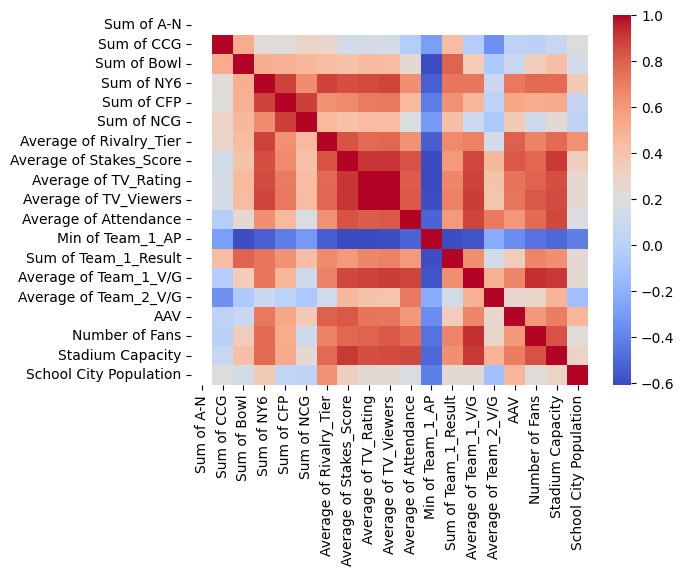

In [4]:
sns.heatmap(df.corr(), cmap='coolwarm', fmt=".2f")

Since there are many correlated variables on the heat map, we will run some models to reduce the number on features on the model. Highly correlated variables could hinder the model and lead to a bad performance.

In [5]:
# Select features (X) and target variable (y)
# Assuming df is your DataFrame
X = df.drop(['Row Labels', 'AAV'], axis=1)
y = df['AAV']

pX = predict.drop(['Row Labels', 'AAV'], axis=1)
py = predict['AAV']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

First I will run a linear regression to have a base model

In [6]:
#Linear Regression

model = sm.OLS(y, X)
results = model.fit()
summarize(results)

c:\Users\MARIA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


,coef,std err,t,P>|t|
Sum of A-N,0.000000e+00,0.000000e+00,NaN,NaN
Sum of CCG,3.745000e+05,5.500000e+05,0.681,0.533
Sum of Bowl,-1.146000e+05,4.780000e+05,-0.240,0.822
Sum of NY6,-1.971000e+07,7.720000e+06,-2.552,0.063
Sum of CFP,3.364000e+07,1.520000e+07,2.216,0.091
Sum of NCG,-4.244000e+07,2.160000e+07,-1.970,0.120
Average of Rivalry_Tier,1.580000e+08,6.970000e+07,2.265,0.086
Average of Stakes_Score,1.061000e+07,4.750000e+06,2.235,0.089
Average of TV_Rating,-3.586000e+06,5.180000e+06,-0.692,0.527
Average of TV_Viewers,2.842000e+06,3.100000e+06,0.916,0.411


In [7]:
#Fit regression with sklearn, predict and evaluate
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

#Predictions vs actual values
print("Predictions\t\tActual")
for i in range(len(predictions)):
    print(predictions[i].round(2), "\t\t", y_test.iloc[i])

#Evaluate
mse = mean_squared_error(y_test, predictions)
print("\nMSE:", round(sqrt(mse), 2))


Predictions		Actual
3167707.55 		 4000000
-467269.77 		 1000000
1673895.02 		 3000000

MSE: 1238836.25


In [8]:
warnings.filterwarnings("ignore")

#Ridge
ridge_model = Ridge(alpha=10)
ridge_model.fit(X_train, y_train)

#Lasso
lasso_model = Lasso(alpha=10)
lasso_model.fit(X_train, y_train)

#Cross-validation
ridge_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

#Mean squared error (MSE)
ridge_mse = -ridge_scores.mean()
lasso_mse = -lasso_scores.mean()

print("Ridge MSE:", round(sqrt(ridge_mse),2))
print("Lasso MSE:", round(sqrt(lasso_mse),2))

ridge_coefficients = ridge_model.coef_
lasso_coefficients = lasso_model.coef_

used_variables_lasso = X.columns[lasso_coefficients == 0]
used_variables_ridge = X.columns[ridge_coefficients == 0]

print("\nRidge coefficients not used: ",used_variables_ridge)
print("Lasso coefficients not used: ",used_variables_lasso)

#Predictions for Ridge and Lasso models
ridge_predictions = ridge_model.predict(X_test)
lasso_predictions = lasso_model.predict(X_test)

predictions_df = pd.DataFrame({'Actual': y_test, 'Ridge': ridge_predictions, 'Lasso': lasso_predictions})

print(predictions_df)

print("Lasso Cross-validated Predictions vs Actual:")
for pred, actual in zip(lasso_predictions, y_train):
    print(f"Predicted: {pred:.2f}\tActual: {actual:.2f}")

print("\nRidge Cross-validated Predictions vs Actual:")
for pred, actual in zip(ridge_predictions, y_train):
    print(f"Predicted: {pred:.2f}\tActual: {actual:.2f}")

Ridge MSE: 991958.25
Lasso MSE: 3312979.23

Ridge coefficients not used:  Index(['Sum of A-N'], dtype='object')
Lasso coefficients not used:  Index(['Sum of A-N'], dtype='object')
     Actual         Ridge         Lasso
0   4000000  1.838289e+06  1.604631e+06
17  1000000  1.286294e+06  1.729584e+06
15  3000000  1.426006e+06  1.141846e+06
Lasso Cross-validated Predictions vs Actual:
Predicted: 1604631.13	Actual: 833333.00
Predicted: 1729584.25	Actual: 2065000.00
Predicted: 1141846.19	Actual: 1500000.00

Ridge Cross-validated Predictions vs Actual:
Predicted: 1838288.74	Actual: 833333.00
Predicted: 1286293.88	Actual: 2065000.00
Predicted: 1426005.95	Actual: 1500000.00


After running Ridge and Lasso regression, we can Ridge performs better than a regression with no regularization, and Lasso worse. However, it only took one variable out of the equation and due to a high collinearity, I believe if more correlated variables are excluded, the results can be better

Below I will run PCA for the final prediction

In [9]:
#PCA
#Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_pca, y_train)

predictions = model.predict(X_test_pca)

#Predictions vs actual values
print("Predictions\t\tActual")
for i in range(len(predictions)):
    print(predictions[i].round(2), "\t\t", y_test.iloc[i])

#Evaluate
mse = mean_squared_error(y_test, predictions)
print("\nMSE:", round(sqrt(mse), 2))

Predictions		Actual
2010033.63 		 4000000
1296195.62 		 1000000
1527355.44 		 3000000

MSE: 1439488.33


PCA performs better than Lasso and worse than normal regression and Ridge. I will now use PCA for feature reduction

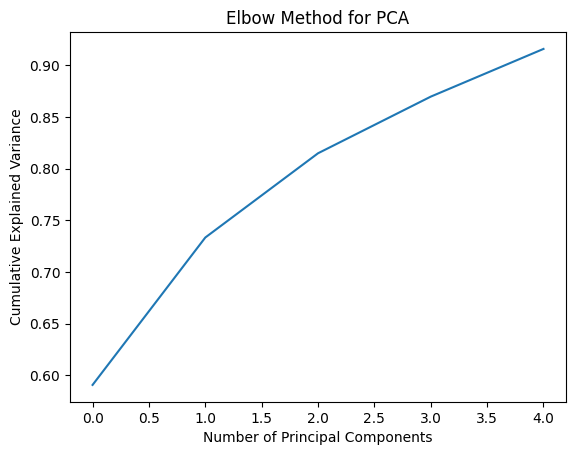

Cross-validated Mean Squared Error: 713753.54
Most important features: ['Average of Stakes_Score', 'Average of Team_2_V/G', 'School City Population', 'Sum of Bowl', 'Min of Team_1_AP']


In [10]:
#Identify features w PCA
num_features = X_train_scaled.shape[1]
most_important_features = []

for component in pca.components_:
    most_important_features.append(np.argmax(np.abs(component)))

#Elbow method
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method for PCA')
plt.show()

#CV
scores = cross_val_score(model, X_train_pca, y_train, cv=14, scoring='neg_mean_squared_error')
mse_cv = -scores.mean()
print("Cross-validated Mean Squared Error:", round(np.sqrt(mse_cv), 2))

original_feature_names = X.columns
most_important_features_names = [original_feature_names[idx] for idx in most_important_features]
print("Most important features:", most_important_features_names)


The elbow method here shows the optimal number of principal components to retain. We will perform the predictions using these variables and see if they perform better than the above PCA prediction using them

In [11]:
#Predict
names = predict["Row Labels"]
new_data_scaled = scaler.transform(pX)

#PCA transformation
new_data_pca = pca.transform(new_data_scaled)
new_data_predictions = model.predict(new_data_pca)

print("Predictions for PCA:")
for name, pred in zip(names, new_data_predictions):
    print(f"Name: {name}: {pred.round(2)}")

Predictions for PCA:
Name: Clemson: 2462086.21


In [12]:
df_filtered = df[["Row Labels", "AAV"] + most_important_features_names]

#Select X and Y
X1 = df_filtered.drop(['Row Labels', 'AAV'], axis=1)
y1 = df_filtered['AAV']

#For Clemson prediction
predict_new = predict[["Row Labels", "AAV"] + most_important_features_names]
pX1 = predict_new.drop(['Row Labels', 'AAV'], axis=1)
py1 = predict_new['AAV']

# Split the dataset into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

In [13]:
#Gradient Boosting
model = GradientBoostingRegressor()
model.fit(X1_train, y1_train)

cv_predictions = cross_val_predict(model, X1_train, y1_train, cv=7)
cv_scores = cross_val_score(model, X1_train, y1_train, cv=7, scoring='neg_mean_squared_error')
mse_cv = -cv_scores.mean()

#Predictions
predictions = model.predict(X1_test)

print("MSE: ", round(np.sqrt(mse_cv), 2))

print("Cross-validated Predictions\tActual")
for i in range(len(cv_predictions)):
    print(cv_predictions[i].round(2), "\t\t\t\t", y1_train.iloc[i])

#Predictions vs actual values
print("Predictions\t\tActual")
for i in range(len(predictions)):
    print(predictions[i].round(2), "\t\t", y1_test.iloc[i])

MSE:  530753.65
Cross-validated Predictions	Actual
997221.35 				 833333
1769921.51 				 2065000
2544579.0 				 1500000
1360815.11 				 1000000
1269839.53 				 2513333
4227969.76 				 4312500
2014916.83 				 1500000
4107731.71 				 4500000
2006317.18 				 1750000
1681896.0 				 1100000
4377956.16 				 4000000
1992060.17 				 2750000
853770.28 				 1000000
834776.49 				 1000000
1491190.04 				 1400000
1746897.13 				 1550000
1667288.47 				 2000000
3293028.28 				 1833333
Predictions		Actual
2304229.51 		 4000000
1279778.48 		 1000000
1030630.37 		 3000000


In [14]:
new_predictions = model.predict(pX1)

print("Predictions for GB:")
for name, pred in zip(names, new_predictions):
    print(f"Name: {name}: {pred.round(2)}")

Predictions for GB:
Name: Clemson: 3077427.39


In [15]:
#KNN
model = KNeighborsRegressor(n_neighbors=1)
model.fit(X1_train, y1_train)

cv_predictions = cross_val_predict(model, X1_train, y1_train, cv=5)
predictions = model.predict(X1_test)

#predictions vs actual values
print("Predictions\t\tActual")
for i in range(len(predictions)):
    print(predictions[i].round(2), "\t\t", y1_test.iloc[i])

#Evaluate
mse = mean_squared_error(y1_test, predictions)
print("\nMSE:", round(sqrt(mse), 2))


print("Cross-validated Predictions\tActual")
for i in range(len(cv_predictions)):
    print(cv_predictions[i].round(2), "\t\t\t\t", y1_train.iloc[i])

Predictions		Actual
2513333.0 		 4000000
1833333.0 		 1000000
4500000.0 		 3000000

MSE: 1310804.16
Cross-validated Predictions	Actual
2000000.0 				 833333
2000000.0 				 2065000
4500000.0 				 1500000
2750000.0 				 1000000
1000000.0 				 2513333
1500000.0 				 4312500
833333.0 				 1500000
4000000.0 				 4500000
1000000.0 				 1750000
1550000.0 				 1100000
4500000.0 				 4000000
1000000.0 				 2750000
1750000.0 				 1000000
1750000.0 				 1000000
2750000.0 				 1400000
1100000.0 				 1550000
2065000.0 				 2000000
2065000.0 				 1833333


In [16]:
#Linear Regression

model = sm.OLS(y1, X1)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
Average of Stakes_Score,7.491000e+06,1280000.000,5.868,0.000
Average of Team_2_V/G,3.949000e+04,209000.000,0.189,0.853
School City Population,4.458000e-01,0.160,2.789,0.013
Sum of Bowl,-9.304000e+04,158000.000,-0.590,0.563
Min of Team_1_AP,1.121000e+04,3024.204,3.707,0.002


In [17]:
# X1_train = X1_train.drop(['Sum of Bowl', 'Average of Team_2_V/G'], axis=1)
# X1_test = X1_test.drop(['Sum of Bowl', 'Average of Team_2_V/G'], axis=1)
# pX1 = pX1.drop(['Sum of Bowl', 'Average of Team_2_V/G'], axis=1)
# X1 = X1.drop(['Sum of Bowl', 'Average of Team_2_V/G'], axis=1)

In [18]:
#Linear Regression

model = sm.OLS(y1, X1)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
Average of Stakes_Score,7.491000e+06,1280000.000,5.868,0.000
Average of Team_2_V/G,3.949000e+04,209000.000,0.189,0.853
School City Population,4.458000e-01,0.160,2.789,0.013
Sum of Bowl,-9.304000e+04,158000.000,-0.590,0.563
Min of Team_1_AP,1.121000e+04,3024.204,3.707,0.002


In [19]:
#Fit model with sklearn, predict and evaluate
model = LinearRegression()
model.fit(X1_train, y1_train)

predictions = model.predict(X1_test)

#Predictions vs actual values
print("Predictions\t\tActual")
for i in range(len(predictions)):
    print(predictions[i].round(2), "\t\t", y1_test.iloc[i])

#Evaluate
mse = mean_squared_error(y1_test, predictions)
print("\nMean Squared Error:", round(sqrt(mse), 2))

new_predictions = model.predict(pX1)

# Printing the new predictions
print("Predictions for LR:")
for i in range(len(new_predictions)):
    print(new_predictions[i].round(2))

Predictions		Actual
2796540.33 		 4000000
1184189.72 		 1000000
1595595.12 		 3000000

Mean Squared Error: 1073094.29
Predictions for LR:
2915544.64


Out of all models tested to predict the naming rights values for Clemson University, the gradient boosting model performed best, with the lowest mean squared error.

SPONSOR

Clustering the sponsors database in order to group similar companies so we can filter the best candidate out of a specific group

In [20]:
sponsor = pd.read_excel("sponsors.xlsx", sheet_name="sponsors")
sponsor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283 entries, 0 to 282
Data columns (total 7 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Company                                283 non-null    object 
 1   Distance from CU                       283 non-null    float64
 2   Estimated Revenue Group (in millions)  283 non-null    int64  
 3   Employees                              283 non-null    int64  
 4   Industries_1                           283 non-null    int64  
 5   Industries_2                           283 non-null    int64  
 6   Industries_3                           283 non-null    int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 15.6+ KB


In [21]:
sponsor_cluster = sponsor.drop("Company", axis=1)
company_names = sponsor['Company']

data_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(sponsor_cluster)
scaled_data

array([[ 1.65800975, 15.89503104, -0.21832962, -0.60238416, -1.15569423,
        -0.63907305],
       [-0.47333252,  1.42320495, -0.11616811, -0.60238416, -1.15569423,
        -0.63907305],
       [-0.47333252,  1.42320495,  0.39463944,  1.55237649,  0.06506397,
         1.43267119],
       ...,
       [-0.47333252, -0.16869592, -0.28711837,  0.14349453, -1.15569423,
        -0.63907305],
       [-0.47333252, -0.16869592, -0.28711837,  1.05512403,  0.72630799,
        -0.63907305],
       [-0.47333252, -0.16869592, -0.21832962, -0.68525957,  0.57371322,
         2.27256751]])

In [22]:
#DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=5)
cluster_labels = dbscan.fit_predict(scaled_data)

#Add cluster labels
sponsor['Cluster'] = cluster_labels
company_clustered = pd.DataFrame({'Company': company_names, 'Cluster': cluster_labels})

#N of observations in each cluster
cluster_counts = company_clustered['Cluster'].value_counts()
cluster_means = sponsor.groupby('Cluster').mean()


print("Observations per cluster:")
print(cluster_counts)

print("Mean values cluster:")
cluster_means

sponsor.to_excel("Cluster.xlsx")

Observations per cluster:
 0    207
 1     66
-1     10
Name: Cluster, dtype: int64
Mean values cluster:
